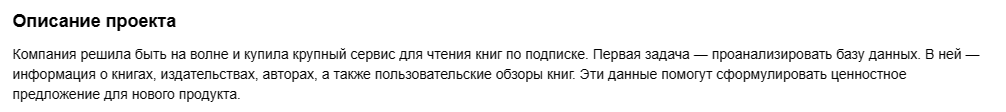

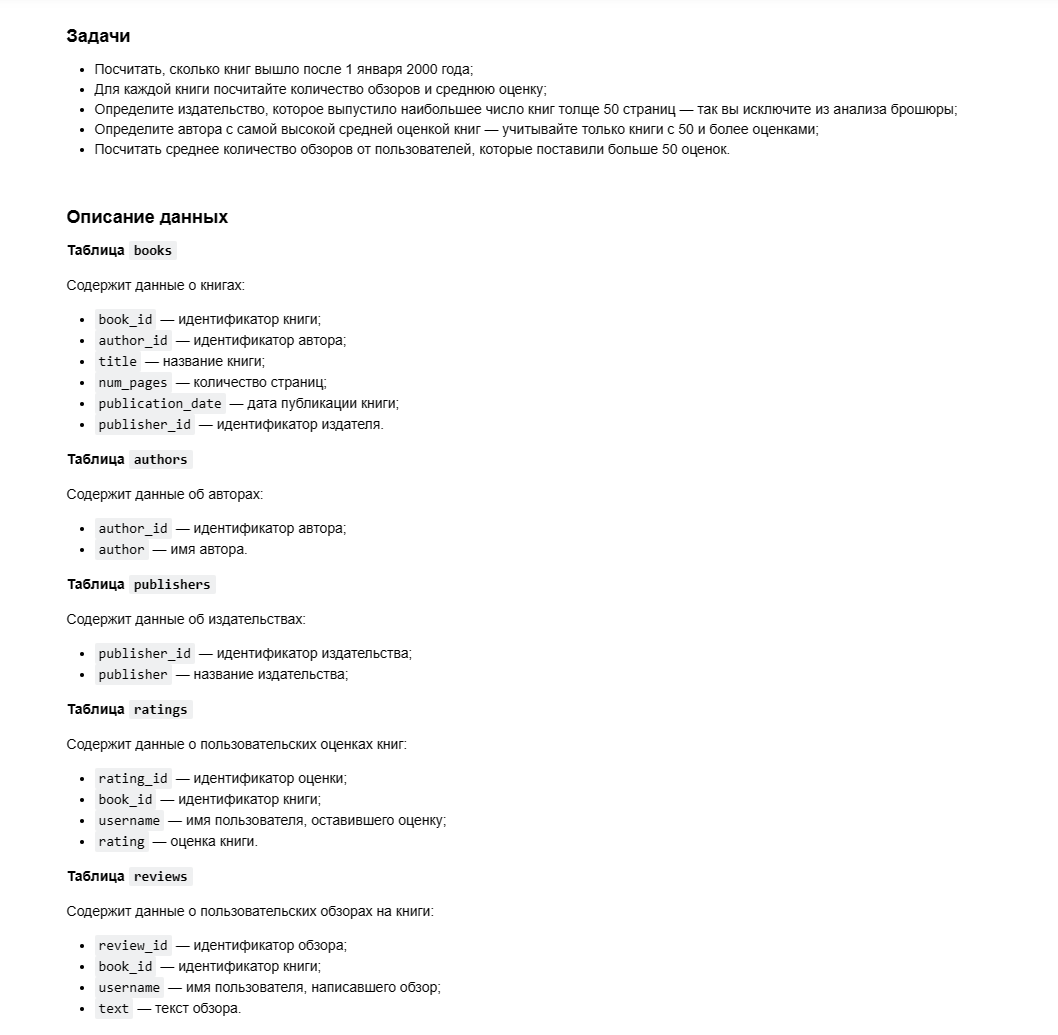

### 1. Загрузка данных и подготовка к анализу

In [1]:
# импортируем библиотеки
import pandas as pd 
from sqlalchemy import create_engine 
from datetime import datetime


In [2]:
# устанавливаем параметры
db_config = {'user': 'praktikum_student', # имя пользователя
 'pwd': 'Sdf4$2;d-d30pp', # пароль
 'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net', 
 'port': 6432, # порт подключения
 'db': 'data-analyst-final-project-db'} # название базы данных
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(db_config['user'], 
 db_config['pwd'], 
 db_config['host'], 
 db_config['port'], 
 db_config['db']) 
# сохраняем коннектор
engine = create_engine(connection_string, connect_args={'sslmode':'require'})

##### Посмотрим на исходные данные

In [3]:
query = ''' SELECT
                *
            FROM
                books
            LIMIT
                5
            '''
print ('Таблица books')
display(pd.io.sql.read_sql(query, con = engine))

Таблица books


,book_id,author_id,title,num_pages,publication_date,publisher_id
0,1,546,'Salem's Lot,594,2005-11-01,93
1,2,465,1 000 Places to See Before You Die,992,2003-05-22,336
2,3,407,13 Little Blue Envelopes (Little Blue Envelope...,322,2010-12-21,135
3,4,82,1491: New Revelations of the Americas Before C...,541,2006-10-10,309
4,5,125,1776,386,2006-07-04,268


In [4]:
query = ''' SELECT
                *
            FROM
                publishers
            LIMIT
                5
            '''
print ('Таблица publishers')
display(pd.io.sql.read_sql(query, con = engine))

Таблица publishers


,publisher_id,publisher
0,1,Ace
1,2,Ace Book
2,3,Ace Books
3,4,Ace Hardcover
4,5,Addison Wesley Publishing Company


In [5]:
query = ''' SELECT
                *
            FROM
                ratings
            LIMIT
                  5
            '''
print ('Таблица ratings')
display(pd.io.sql.read_sql(query, con = engine))

Таблица ratings


,rating_id,book_id,username,rating
0,1,1,ryanfranco,4
1,2,1,grantpatricia,2
2,3,1,brandtandrea,5
3,4,2,lorichen,3
4,5,2,mariokeller,2


In [6]:
query = ''' SELECT
                *
            FROM
                reviews
            LIMIT
                 5
            '''
print ('Таблица reviews')
display(pd.io.sql.read_sql(query, con = engine))

Таблица reviews


,review_id,book_id,username,text
0,1,1,brandtandrea,Mention society tell send professor analysis. ...
1,2,1,ryanfranco,Foot glass pretty audience hit themselves. Amo...
2,3,2,lorichen,Listen treat keep worry. Miss husband tax but ...
3,4,3,johnsonamanda,Finally month interesting blue could nature cu...
4,5,3,scotttamara,Nation purpose heavy give wait song will. List...


### 2. Посчитаем, сколько книг вышло после 1 января 2000 года

In [7]:
query = ''' SELECT 
                COUNT(book_id) as cnt_book

                FROM books
                WHERE publication_date::TIMESTAMP >= '2000-01-01'
            '''
books = pd.io.sql.read_sql(query, con = engine)
print('Количество книг выпущенных после 2000-01-01:')
print(books)

Количество книг выпущенных после 2000-01-01:
   cnt_book
0       821


### Вывод
После 1 января 2000 года вышло 821 книга

### 3. Для каждой книги посчитайте количество обзоров и среднюю оценку

In [8]:
query = ''' SELECT
                books.book_id AS book_id,
                books.title AS title,
                ratings.avg_rating AS avg_rating,
                reviews.cnt_review_id AS review_number
            FROM
                books
                LEFT JOIN (SELECT 
                                  ratings.book_id AS ratings_book_id,
                                  AVG(ratings.rating) AS avg_rating
                            FROM
                                  ratings
                            GROUP BY
                                    ratings.book_id) AS ratings ON ratings.ratings_book_id = books.book_id
                LEFT JOIN (SELECT 
                                  reviews.book_id AS reviews_book_id,
                                  COUNT(reviews.review_id) AS cnt_review_id
                            FROM
                                  reviews
                            GROUP BY
                                    reviews.book_id) AS reviews ON reviews.reviews_book_id = books.book_id
            GROUP BY
                book_id,
                title,
                avg_rating,
                review_number
                
            ORDER BY
                book_id
            
            '''
ratings_reviews = pd.io.sql.read_sql(query, con = engine)
display(ratings_reviews)

,book_id,title,avg_rating,review_number
0,1,'Salem's Lot,3.666667,2.0
1,2,1 000 Places to See Before You Die,2.500000,1.0
2,3,13 Little Blue Envelopes (Little Blue Envelope...,4.666667,3.0
3,4,1491: New Revelations of the Americas Before C...,4.500000,2.0
4,5,1776,4.000000,4.0
...,...,...,...,...
995,996,Wyrd Sisters (Discworld #6; Witches #2),3.666667,3.0
996,997,Xenocide (Ender's Saga #3),3.400000,3.0
997,998,Year of Wonders,3.200000,4.0
998,999,You Suck (A Love Story #2),4.500000,2.0


### 4. Определите издательство, которое выпустило наибольшее число книг толще 50 страниц — так вы исключите из анализа брошюры

In [9]:
query = ''' SELECT
                COUNT(books.publisher_id) AS cnt_publisher_id,
                publishers.publisher AS publisher
            FROM
                publishers
            INNER JOIN books ON books.publisher_id = publishers.publisher_id 
    
            WHERE 
                books.num_pages > 50
    
            GROUP BY
                publishers.publisher 
                
            ORDER BY
                cnt_publisher_id DESC
            LIMIT
                1
    
            '''
books_publishers = pd.io.sql.read_sql(query, con = engine)
display(books_publishers)

,cnt_publisher_id,publisher
0,42,Penguin Books


### Вывод
Издательство 'Penguin Books' выпустило 42 книги толще 50 страниц

### 5. Определите автора с самой высокой средней оценкой книг — учитывайте только книги с 50 и более оценками

In [12]:
query = '''SELECT
                authors.author AS author,
                books.author_id AS author_id,
                ratings_sort.book_id AS book_id,
                AVG(ratings_sort.avg_rating) AS avg_rating
            FROM
                books             
            INNER JOIN (SELECT
                            book_id AS book_id,
                            AVG(rating) AS avg_rating,
                            COUNT(rating_id) as cnt_rating_id
                        FROM 
                              ratings
                        GROUP BY
                              book_id
                        HAVING 
                            COUNT(rating_id) >=50) AS ratings_sort ON ratings_sort.book_id = books.book_id
            LEFT JOIN authors ON authors.author_id = books.author_id
                
            GROUP BY
                authors.author,
                books.author_id,
                ratings_sort.book_id
              
            ORDER BY
                avg_rating DESC
            
            LIMIT
                1
            '''
author_rating = pd.io.sql.read_sql(query, con = engine)
display(author_rating)

,author,author_id,book_id,avg_rating
0,J.K. Rowling/Mary GrandPré,236,302,4.414634


### Вывод
J.K. Rowling/Mary GrandPré - автор с самой высокой средней оценкой книг

### 6. Посчитать среднее количество обзоров от пользователей, которые поставили больше 50 оценок

In [13]:
query = '''WITH rating_50 AS(
                SELECT username  AS username,
                    COUNT(rating_id) as cnt_rating
                FROM
                    ratings
                GROUP BY username
                HAVING COUNT(rating_id)>=50)

            SELECT
                AVG(Sub.cnt_review_id) AS avg_number_review
            FROM
                
                (SELECT 
                    username  AS username,
                    COUNT(review_id) AS cnt_review_id
                FROM
                    reviews
                WHERE
                    username IN (SELECT username FROM rating_50)
                GROUP BY 
                    username) AS Sub
                        '''
username_reviews = pd.io.sql.read_sql(query, con = engine)
display(username_reviews)

,avg_number_review
0,24.222222


### Вывод
Среднее количество обзоров от пользователей около 24